<a href="https://colab.research.google.com/github/tomhruby1/zdo/blob/main/run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import sys
import math
import json
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from pathlib import Path
import torch
import torch.nn.functional as F
import copy
from torchvision.io import read_image
import scipy.interpolate
import skimage.feature
from sklearn.linear_model import LinearRegression
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)

In [ ]:


def intersectLines( pt1, pt2, ptA, ptB ):
    """ this returns the intersection of Line(pt1,pt2) and Line(ptA,ptB)

        returns a tuple: (xi, yi, valid, r, s), where
        (xi, yi) is the intersection
        r is the scalar multiple such that (xi,yi) = pt1 + r*(pt2-pt1)
        s is the scalar multiple such that (xi,yi) = pt1 + s*(ptB-ptA)
            valid == 0 if there are 0 or inf. intersections (invalid)
            valid == 1 if it has a unique intersection ON the segment    """

    DET_TOLERANCE = 0.00000001

    x1, y1 = pt1;   x2, y2 = pt2
    dx1 = x2 - x1;  dy1 = y2 - y1

    x, y = ptA;   xB, yB = ptB;
    dx = xB - x;  dy = yB - y;

    #
    DET = (-dx1 * dy + dy1 * dx)

    if math.fabs(DET) < DET_TOLERANCE: return (0,0,0,0,0)

    # now, the determinant should be OK
    DETinv = 1.0/DET

    # find the scalar amount along the "self" segment
    r = DETinv * (-dy  * (x-x1) +  dx * (y-y1))

    # find the scalar amount along the input line
    s = DETinv * (-dy1 * (x-x1) + dx1 * (y-y1))

    # return the average of the two descriptions
    xi = (x1 + r*dx1 + x + s*dx)/2.0
    yi = (y1 + r*dy1 + y + s*dy)/2.0

    ##############
    #found is intersection (xi,yi) in inner segment
    valid = 0
    if x1 != x2:
        if x1 < x2:
            a = x1
            b = x2
        else:
            a = x2
            b = x1
        c = xi
    else:
        #predpoklad, ze pak y jsou ruzne
        if y1 < y2:
            a = y1
            b = y2
        else:
            a = y2
            b = y1
        c = yi
    if (c > a) and (c < b):
        #now second segment
        if x != xB:
            if x < xB:
                a = x
                b = xB
            else:
                a = xB
                b = x
            c = xi
        else:
            #predpoklad, ze pak y jsou ruzne
            if y < yB:
                a = y
                b = yB
            else:
                a = yB
                b = y
            c = yi
        if (c > a) and (c < b):
            valid = 1

    return ( xi, yi, valid, r, s )


In [ ]:
def slope(x1, y1, x2, y2): # Line slope given two points:
    return (y2-y1)/(x2-x1)

def angle(s1, s2): 
    return math.degrees(math.atan((s2-s1)/(1+(s2*s1))))

In [ ]:
def visualize(data,stitches, image_id):
    '''Visualizes image and it's Incission and Stitch annotations'''


    COLOR = {
    'Incision': 'red',
    'Stitch': 'green',
    'incision': 'red',
    'stitch': 'green'
    }
    image_path = data[image_id]['file']
    image = mpimg.imread(image_path)
    
    fig, ax = plt.subplots()
    ax.imshow(image)
    for stitch in stitches:
      plt.plot(stitch[0][0], stitch[0][1],'yo-')
      plt.plot(stitch[1][0], stitch[1][1],'yo-')
      x_values = [stitch[0][0], stitch[1][0]]
      y_values = [stitch[0][1], stitch[1][1]]
      plt.plot(x_values, y_values, 'y', linestyle="-")

    for idx, label in enumerate(data[image_id]['label']):
        points = data[image_id]['points'][idx]
        x_coords, y_coords = zip(*points)
        x_coords = np.array(x_coords, dtype=float)
        y_coords = np.array(y_coords, dtype=float)
        ax.plot(x_coords, y_coords, color=COLOR[label], linewidth=2)
    # Show the plot
    plt.show()

In [ ]:

def inverse_interpolate(data,image_id,im):
        size=(128,255)
        data_new = copy.deepcopy(data)
        print(im.shape)
        inter_coeff = (size[1]/im.shape[3], size[0]/im.shape[2])
        for i, st in enumerate(data[str(image_id)]['stitches']):
            for j,pt in enumerate(st):
                pt = np.array(pt, dtype=float)
                pt *= inter_coeff
                data_new[str(image_id)]['stitches'][i][j] = list(pt)
        for i, pt in enumerate(data[str(image_id)]['incision']):
            pt = np.array(pt, dtype=float)
            pt *= inter_coeff
            
            
            data_new[str(image_id)]['incision'][i] = list(pt)
        return data_new

In [ ]:
def line_interpolate(x,y):
  x=np.array(x).reshape(-1, 1) 
  y=np.array(y)
  linear_regressor = LinearRegression()
  linear_regressor.fit(x, y)
  print(x[0])
  return [[x[0][0],float(linear_regressor.predict([x[0]]))],[x[-1][0],float(linear_regressor.predict([x[-1]]))]]


In [71]:
def detect_stitches(image_id):
  image_path = data[image_id]['file']
  image = mpimg.imread(image_path)
  from skimage.transform import hough_circle,hough_circle_peaks
  edge_canny = skimage.feature.canny(image, sigma=0.98)
  plt.imshow(edge_canny, cmap='gray')

  hough_radii = np.arange(3, 20, 1)
  hough_res=hough_circle(edge_canny, hough_radii)
  accums, center_x, center_y, radii = hough_circle_peaks(hough_res, hough_radii,
                                            min_ydistance=int(edge_canny.shape[0]/5),min_xdistance=int(edge_canny.shape[1]/12),total_num_peaks=20)
  i=0
  stitches_1=[]
  stitches_2=[]
  for x in center_x:
    j=0
    for x_2 in center_x:
      if -20<x-x_2<20 and x-x_2!=0:
        if [x,center_y[i]] not in stitches_1 and [x,center_y[i]] not in stitches_2:
          if [x_2,center_y[j]] not in stitches_1 and [x_2,center_y[j]] not in stitches_2:
            stitches_1.append([x,center_y[i]])
            stitches_2.append([x_2,center_y[j]])
        
      j+=1
    i+=1

  stitches=[] 
  print(stitches_1)
  print(stitches_2)
  for x in range(len(stitches_1)):
    stitches.append([stitches_1[x],stitches_2[x]])
  return stitches


torch.Size([1, 3, 128, 255])
X:  [45.94, 67.04375, 88.14750000000001, 109.25125000000001, 130.35500000000002, 172.5625, 193.66625, 214.77, 251.29250000000002, 287.815, 324.3375, 360.86, 394.32, 427.78, 461.24, 494.7]
y:  [110.45, 110.0125, 109.575, 109.1375, 108.7, 107.825, 107.3875, 106.95, 103.3425, 99.735, 96.1275, 92.52, 92.0825, 91.645, 91.2075, 90.77]
[45.94]
New insision:  [[45.94, 112.5800477358573], [494.7, 88.86479629257029]]
[408.01670656684576, 338.97052532716157, 265.2574847699523, 192.12159337166523, 124.04794686121159, 39.79649928102388]


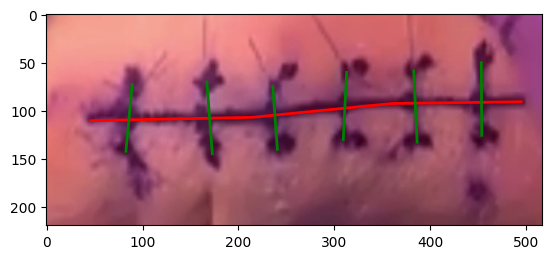

In [ ]:
if __name__ == "__main__":
    args=sys.argv
    output_file=args[1]
    visual_mode=True
    if args[2]=="-v":
      visual_mode=True
      input_imgs=args[3:]
    else:
      input_imgs=args[2:]
    for img in input_imgs:
      image= read_image("SA_20230222-130058_incision_crop_0.jpg")
      image = image.unsqueeze(0)
      interpolated_image=F.interpolate(image, size=(128,255)) # size=(3,128,255)

      #TODO:Metoda, která má jako vstup název obrázku, vrací json s incision a stiches
      f = open('data_processed.json')
      input_json=json.load(f)
      img_no="53"
      input_json=inverse_interpolate(input_json,img_no,interpolated_image)
      
      x=[]
      for x_cord in input_json[img_no]["incision"]:
        print
        x.append(x_cord[0])
      y=[]
      for y_cord in input_json[img_no]["incision"]:
        y.append(y_cord[1])
      incision=line_interpolate(x,y)
      print("New insision: ",incision )
      stitches=detect_stitches()


      #nalezení pruseciku
      stitch_intersections=[]
      crossing_angles=[]
      for stitch in stitches:
        stitch_intersections.append(intersectLines( [float(incision[0][0]),float(incision[0][1])], [float(incision[1][0]),float(incision[1][1])],
                              [float(stitch[0][0]),float(stitch[0][1])], [float(stitch[1][0]),float(stitch[1][1])] ))
        

        #urceni uhlu ktery spolu svírají jizva a stehy
        lineA = ([float(incision[0][0]),float(incision[0][1])], [float(incision[1][0]),float(incision[1][1])])
        lineB = ([float(stitch[0][0]),float(stitch[0][1])], [float(stitch[1][0]),float(stitch[1][1])])

        slope1 = slope(lineA[0][0], lineA[0][1], lineA[1][0], lineA[1][1])
        slope2 = slope(lineB[0][0], lineB[0][1], lineB[1][0], lineB[1][1])

        crossing_angles.append(abs(angle(slope1, slope2)))#?????
      crossing_positions=[]  
      for x in stitch_intersections:
        crossing_positions.append(math.sqrt((float(incision[0][0])-x[0])**2+(float(incision[0][1])-x[1])**2))
      print(crossing_positions)


      

        

      data = [
          { "filename": img_no,
            "incision_polyline": [[ float(incision[0][0]), float(incision[0][1])],[float(incision[1][0]),float(incision[1][1])]],
            "crossing_positions": crossing_positions,
            "crossing_angles": crossing_angles,
          }, 
        ]


      with open('data.json', 'w', encoding='utf-8') as f:
          json.dump(data, f, ensure_ascii=False, indent=4)
    
      if visual_mode:
        visualize(input_json,stitches,img_no)







